# Notebook to parse existing DLD diagnoses based on CELF sub scores

In [4]:
import numpy as np
import pandas as pd
import re
import math
from matplotlib import pyplot as plt

In [5]:
#load 2 celf data csvs
dx_file = '../sourcedata/data/HBN/phenotype/CELF_Full_9to21_data-2022-02-10T18_47_12.931Z.csv'
dx_file5 = '../sourcedata/data/HBN/phenotype/CELF_Full_5to8_data-2022-02-10T18_45_52.391Z.csv'
dx = pd.read_csv(dx_file)
dx5 = pd.read_csv(dx_file5)
dx.columns = ['id','comp_CLS','completed','comp_ELI','ind_FD','ind_FS','comp_LCI','comp_LMI','comp_RLI','ind_RS','ind_SA','ind_SR','ind_USP','valid','ind_WC','ind_WD','site']
dx5.columns = ['id','comp_CLS','completed','comp_ELI','ind_FD','ind_FS','comp_LCI','ind_LC','comp_LSI','comp_RLI','ind_RS','ind_SC','ind_USP','valid','ind_WC','ind_WS','site']

#put id column first
dx = dx.reindex(sorted(dx.columns), axis=1)
first_column = dx.pop('id')
dx.insert(0, 'id', first_column)

dx5 = dx5.reindex(sorted(dx5.columns), axis=1)
first_column = dx5.pop('id')
dx5.insert(0, 'id', first_column)
#combine them
df = dx.append(dx5)

In [3]:
#save CELF data to a csv
df.to_csv('../sourcedata/data/HBN/phenotype/parsed/celf_parsed.csv', index=False)

PermissionError: [Errno 13] Permission denied: '../sourcedata/data/HBN/phenotype/parsed/celf_parsed.csv'

In [6]:
#get just the celf subscores
df_ind = df[['ind_FD','ind_FS','ind_RS','ind_SA','ind_SR', 'ind_USP','ind_WC','ind_WD','ind_LC','ind_SC','ind_WS']]

In [7]:
individual_scores=df_ind.to_numpy()
individual_scores=np.where(individual_scores<8,1, 0) #set scores that are below cutoff to 1, all else 0
#individual_scores=np.where(individual_scores<9,1, 0) #more lenient settings

In [8]:
individual_scores = np.where( np.sum(individual_scores,axis=1)>1 , 1, 0 )

In [9]:
#put IDs in a list and trim them
sub_list = dx.id.tolist()
sub_list = [elem[:12] for elem in sub_list]

sub_list5 = dx5.id.tolist()
sub_list5 = [elem[:12] for elem in sub_list5]

sub_list.extend(sub_list5) #combine into 1 subject list

In [10]:
language_diff=[] #list of individual IDs that meet criteria of 2 celf subscores < 2SD below mean
for i,score in enumerate(individual_scores):
    if score ==1:
        language_diff.append(sub_list[i])

In [54]:
np.save('../sourcedata/data/HBN/phenotype/parsed/dx_language_diff.npy',language_diff)

## exploring concurrent diagnoses of people that meet our CELF criteria

In [11]:
#load previously saved data and into dataframe
all_dx=np.load('../sourcedata/data/HBN/phenotype/parsed/dx_list.npy')
sub_list=np.load('../sourcedata/data/HBN/phenotype/parsed/sub_list.npy')
dx_array=np.load('../sourcedata/data/HBN/phenotype/parsed/dx_onehot.npy')
dx_df = pd.DataFrame(dx_array)
dx_df.columns = all_dx

In [12]:
# get indices of people that have lower language scores
language_diff_ind=[]
for i,sub in enumerate(language_diff):
    language_diff_ind.extend( np.asarray(np.where(sub_list==sub)).flatten() )

In [15]:
#print and count comorbidities
language_df = dx_df.iloc[language_diff_ind]
language_sum = language_df.sum()
print('comorbid w/DLD cutoff:')
print(language_sum.to_string())

comorbid w/DLD cutoff:
ADHD-Combined Type                                                              52.0
ADHD-Hyperactive/Impulsive Type                                                  0.0
ADHD-Inattentive Type                                                           54.0
Acute Stress Disorder                                                            0.0
Adjustment Disorders                                                             6.0
Agoraphobia                                                                      2.0
Alcohol Use Disorder                                                             0.0
Anorexia Nervosa-Binge Eating/Purging Type                                       0.0
Anorexia Nervosa-Restricting Type                                                0.0
Autism Spectrum Disorder                                                        61.0
Avoidant/Restrictive Food Intake Disorder                                        1.0
Binge-Eating Disorder                     

Text(0.5, 1.0, 'Overlapping Diagnoses of individuals below DLD CELF cutoff n=189')

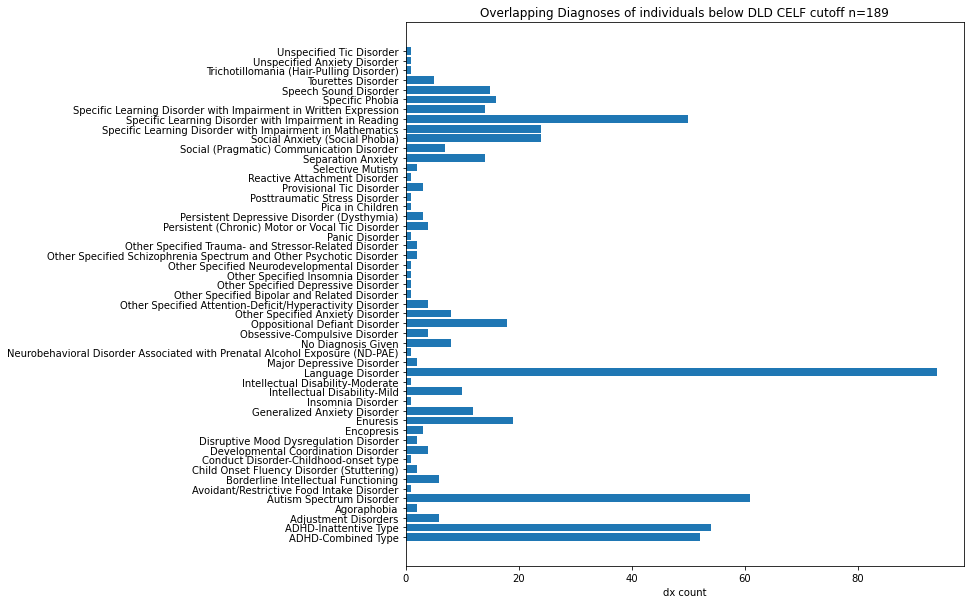

In [16]:
## plot comorbidities as bar chart
dx_name_list = []
dx_val_list = []
for i,n in enumerate(language_sum):
    if n>0:
        dx_name_list.append(language_sum.index[i])
        dx_val_list.append(n)
        
x=np.arange(len(dx_val_list))

plt.figure(figsize=(10, 10),facecolor='white')
plt.xlabel('dx count')

plt.barh(x,dx_val_list,tick_label=dx_name_list)
plt.title('Overlapping Diagnoses of individuals below DLD CELF cutoff n=189')

# look at overlaps with different disorders and combinations in this group - who should be excluded, what to be considered for shared etiology?

In [17]:
LD = language_df.loc[(language_df['Language Disorder'] == 1)]
LD

,ADHD-Combined Type,ADHD-Hyperactive/Impulsive Type,ADHD-Inattentive Type,Acute Stress Disorder,Adjustment Disorders,Agoraphobia,Alcohol Use Disorder,Anorexia Nervosa-Binge Eating/Purging Type,Anorexia Nervosa-Restricting Type,Autism Spectrum Disorder,...,Tourettes Disorder,Trichotillomania (Hair-Pulling Disorder),Unspecified Anxiety Disorder,Unspecified Attention-Deficit/Hyperactivity Disorder,Unspecified Bipolar and Related Disorder,Unspecified Depressive Disorder,Unspecified Intellectual Disability,Unspecified Neurodevelopmental Disorder,Unspecified Tic Disorder,Unspecified Trauma- and Stressor-Related Disorder
104,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
202,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
no_adhd = language_df.loc[((language_df['ADHD-Combined Type'] == 0) & (language_df['ADHD-Hyperactive/Impulsive Type'] == 0) & (language_df['ADHD-Inattentive Type'] == 0) )]
no_adhd

,ADHD-Combined Type,ADHD-Hyperactive/Impulsive Type,ADHD-Inattentive Type,Acute Stress Disorder,Adjustment Disorders,Agoraphobia,Alcohol Use Disorder,Anorexia Nervosa-Binge Eating/Purging Type,Anorexia Nervosa-Restricting Type,Autism Spectrum Disorder,...,Tourettes Disorder,Trichotillomania (Hair-Pulling Disorder),Unspecified Anxiety Disorder,Unspecified Attention-Deficit/Hyperactivity Disorder,Unspecified Bipolar and Related Disorder,Unspecified Depressive Disorder,Unspecified Intellectual Disability,Unspecified Neurodevelopmental Disorder,Unspecified Tic Disorder,Unspecified Trauma- and Stressor-Related Disorder
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
no_adhd_sum = no_adhd.sum()
print('DLD cutoff AND no ADHD:')
print(no_adhd_sum.to_string())

DLD cutoff AND no ADHD:
ADHD-Combined Type                                                               0.0
ADHD-Hyperactive/Impulsive Type                                                  0.0
ADHD-Inattentive Type                                                            0.0
Acute Stress Disorder                                                            0.0
Adjustment Disorders                                                             3.0
Agoraphobia                                                                      2.0
Alcohol Use Disorder                                                             0.0
Anorexia Nervosa-Binge Eating/Purging Type                                       0.0
Anorexia Nervosa-Restricting Type                                                0.0
Autism Spectrum Disorder                                                        19.0
Avoidant/Restrictive Food Intake Disorder                                        0.0
Binge-Eating Disorder                    

In [20]:
no_asd = language_df.loc[(language_df['Autism Spectrum Disorder'] == 0)]
no_asd

,ADHD-Combined Type,ADHD-Hyperactive/Impulsive Type,ADHD-Inattentive Type,Acute Stress Disorder,Adjustment Disorders,Agoraphobia,Alcohol Use Disorder,Anorexia Nervosa-Binge Eating/Purging Type,Anorexia Nervosa-Restricting Type,Autism Spectrum Disorder,...,Tourettes Disorder,Trichotillomania (Hair-Pulling Disorder),Unspecified Anxiety Disorder,Unspecified Attention-Deficit/Hyperactivity Disorder,Unspecified Bipolar and Related Disorder,Unspecified Depressive Disorder,Unspecified Intellectual Disability,Unspecified Neurodevelopmental Disorder,Unspecified Tic Disorder,Unspecified Trauma- and Stressor-Related Disorder
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3177,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
no_adhd_asd = language_df.loc[((language_df['ADHD-Combined Type'] == 0) & (language_df['ADHD-Hyperactive/Impulsive Type'] == 0) & (language_df['ADHD-Inattentive Type'] == 0) & (language_df['Autism Spectrum Disorder'] == 0) )]

In [22]:
no_adhd_asd

,ADHD-Combined Type,ADHD-Hyperactive/Impulsive Type,ADHD-Inattentive Type,Acute Stress Disorder,Adjustment Disorders,Agoraphobia,Alcohol Use Disorder,Anorexia Nervosa-Binge Eating/Purging Type,Anorexia Nervosa-Restricting Type,Autism Spectrum Disorder,...,Tourettes Disorder,Trichotillomania (Hair-Pulling Disorder),Unspecified Anxiety Disorder,Unspecified Attention-Deficit/Hyperactivity Disorder,Unspecified Bipolar and Related Disorder,Unspecified Depressive Disorder,Unspecified Intellectual Disability,Unspecified Neurodevelopmental Disorder,Unspecified Tic Disorder,Unspecified Trauma- and Stressor-Related Disorder
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
cleanest = language_df.loc[((language_df['ADHD-Combined Type'] == 0) & (language_df['ADHD-Hyperactive/Impulsive Type'] == 0) & (language_df['ADHD-Inattentive Type'] == 0) & (language_df['Autism Spectrum Disorder'] == 0) & (language_df['Borderline Intellectual Functioning'] == 0) & (language_df['Autism Spectrum Disorder'] == 0) & (language_df['Borderline Intellectual Functioning'] == 0) & (language_df['Child Onset Fluency Disorder (Stuttering)'] == 0) & (language_df['Developmental Coordination Disorder'] == 0) & (language_df['Persistent (Chronic) Motor or Vocal Tic Disorder'] == 0) & (language_df['Intellectual Disability-Moderate'] == 0) & (language_df['Neurobehavioral Disorder Associated with Prenatal Alcohol Exposure (ND-PAE)'] == 0) & (language_df['Borderline Intellectual Functioning'] == 0) & (language_df['Provisional Tic Disorder'] == 0) & (language_df['Social (Pragmatic) Communication Disorder'] == 0) & (language_df['Speech Sound Disorder'] == 0) & (language_df['Tourettes Disorder'] == 0) & (language_df['Unspecified Tic Disorder'] == 0) )]

In [26]:
cleanest.index

Int64Index([ 174,  218,  298, 1009, 1129, 1172, 1211, 1367, 1432, 1919, 1925,
            1978, 1998, 2250, 2278, 2406, 2435, 2471, 2517, 2531, 2888, 3120,
            3306, 3349, 3366, 3449, 3579,  138,  445,  625,  687,  739,  743,
             770, 1112, 1189, 1254, 1280, 1352, 1417, 1606, 1820, 1860, 1863,
            2141, 2337, 2343, 2468, 2565, 2849, 3060],
           dtype='int64')

In [30]:
for s in sub_list[cleanest.index]:
    print(s)

NDARBA381JGH
NDARBH024NH2
NDARBX974XDR
NDARGG271EFG
NDARGZ553TMQ
NDARHG152GZC
NDARHN131ZP6
NDARJH763NPD
NDARJT615WM7
NDARMT461DNB
NDARMT898BME
NDARMZ477MNH
NDARNB440UE4
NDARPM105MKA
NDARPV249ZRF
NDARRT038VG1
NDARRW475MPT
NDARRZ606EDP
NDARTF566PYH
NDARTH473LF8
NDARVL555VVA
NDARWX380JJK
NDARYA556KP8
NDARYF368WEA
NDARYH110YV9
NDARYX572VEW
NDARZU279XR3
NDARAV454VF0
NDARCW094JCG
NDARDZ321FMY
NDAREJ923AYR
NDARET632ELD
NDARET949LMU
NDAREX336AC1
NDARGX443CEU
NDARHJ945PV0
NDARHU391FD7
NDARHX021WA4
NDARJG488XHT
NDARJP948FJV
NDARKV965WLU
NDARMD700NUE
NDARMJ334ZK3
NDARMJ845MJA
NDARNX218UY5
NDARRE214UKF
NDARRF525ME3
NDARRZ145TFN
NDARTN158LRF
NDARVE724GEF
NDARWP112TDL


In [ ]:
no_adhd_asd = language_df.loc[((language_df['ADHD-Combined Type'] == 0) & (language_df['ADHD-Hyperactive/Impulsive Type'] == 0) & (language_df['ADHD-Inattentive Type'] == 0) & (language_df['Autism Spectrum Disorder'] == 0) )]

In [34]:
dx_df

,ADHD-Combined Type,ADHD-Hyperactive/Impulsive Type,ADHD-Inattentive Type,Acute Stress Disorder,Adjustment Disorders,Agoraphobia,Alcohol Use Disorder,Anorexia Nervosa-Binge Eating/Purging Type,Anorexia Nervosa-Restricting Type,Autism Spectrum Disorder,...,Tourettes Disorder,Trichotillomania (Hair-Pulling Disorder),Unspecified Anxiety Disorder,Unspecified Attention-Deficit/Hyperactivity Disorder,Unspecified Bipolar and Related Disorder,Unspecified Depressive Disorder,Unspecified Intellectual Disability,Unspecified Neurodevelopmental Disorder,Unspecified Tic Disorder,Unspecified Trauma- and Stressor-Related Disorder
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3611,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
language_diff_ind

189

In [ ]:
language_diff_col=[]
for i in range(3615):
    if i in language_diff_ind:
        language_diff_col.append(1)
    else:
        language_diff_col.append(0)

In [43]:
dx_df.insert(0, "DLD", language_diff_col, True)

In [59]:
only_adhd= dx_df.loc[( ((dx_df['ADHD-Combined Type'] == 1) | (dx_df['ADHD-Hyperactive/Impulsive Type'] == 1) | (dx_df['ADHD-Inattentive Type'] == 1) |  (dx_df['Unspecified Attention-Deficit/Hyperactivity Disorder'] == 1) ) & (dx_df['Autism Spectrum Disorder'] == 0) & (dx_df['DLD'] == 0) )]
only_adhd

,DLD,ADHD-Combined Type,ADHD-Hyperactive/Impulsive Type,ADHD-Inattentive Type,Acute Stress Disorder,Adjustment Disorders,Agoraphobia,Alcohol Use Disorder,Anorexia Nervosa-Binge Eating/Purging Type,Anorexia Nervosa-Restricting Type,...,Tourettes Disorder,Trichotillomania (Hair-Pulling Disorder),Unspecified Anxiety Disorder,Unspecified Attention-Deficit/Hyperactivity Disorder,Unspecified Bipolar and Related Disorder,Unspecified Depressive Disorder,Unspecified Intellectual Disability,Unspecified Neurodevelopmental Disorder,Unspecified Tic Disorder,Unspecified Trauma- and Stressor-Related Disorder
1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3602,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3605,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3608,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
only_asd= dx_df.loc[((dx_df['ADHD-Combined Type'] == 0) & (dx_df['ADHD-Hyperactive/Impulsive Type'] == 0) & (dx_df['ADHD-Inattentive Type'] == 0) &  (dx_df['Unspecified Attention-Deficit/Hyperactivity Disorder'] == 0) & (dx_df['Autism Spectrum Disorder'] == 1) & (dx_df['DLD'] == 0) )]
only_asd

42      0
63      0
76      0
89      0
90      0
       ..
3565    0
3609    0
3610    0
3612    0
3613    0
Name: DLD, Length: 123, dtype: int64

In [62]:
only_adhd_asd= dx_df.loc[( ( (dx_df['ADHD-Combined Type'] == 1) | (dx_df['ADHD-Hyperactive/Impulsive Type'] == 1) | (dx_df['ADHD-Inattentive Type'] == 1) |  (dx_df['Unspecified Attention-Deficit/Hyperactivity Disorder'] == 1) ) & (dx_df['Autism Spectrum Disorder'] == 1) & (dx_df['DLD'] == 0) )]
only_adhd_asd

7       1.0
25      1.0
30      1.0
43      1.0
48      1.0
       ... 
3581    1.0
3591    1.0
3597    1.0
3600    1.0
3606    1.0
Name: Autism Spectrum Disorder, Length: 355, dtype: float64

# compare "language disorder" to our DLD criteria

In [67]:
only_ld= dx_df.loc[( (dx_df['Language Disorder'] == 1) & (dx_df['DLD'] == 0) )]
only_ld

,DLD,ADHD-Combined Type,ADHD-Hyperactive/Impulsive Type,ADHD-Inattentive Type,Acute Stress Disorder,Adjustment Disorders,Agoraphobia,Alcohol Use Disorder,Anorexia Nervosa-Binge Eating/Purging Type,Anorexia Nervosa-Restricting Type,...,Tourettes Disorder,Trichotillomania (Hair-Pulling Disorder),Unspecified Anxiety Disorder,Unspecified Attention-Deficit/Hyperactivity Disorder,Unspecified Bipolar and Related Disorder,Unspecified Depressive Disorder,Unspecified Intellectual Disability,Unspecified Neurodevelopmental Disorder,Unspecified Tic Disorder,Unspecified Trauma- and Stressor-Related Disorder
3,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
62,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3513,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3521,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3558,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3575,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
only_dld= dx_df.loc[( (dx_df['Language Disorder'] == 0) & (dx_df['DLD'] == 1) )]
only_dld

,DLD,ADHD-Combined Type,ADHD-Hyperactive/Impulsive Type,ADHD-Inattentive Type,Acute Stress Disorder,Adjustment Disorders,Agoraphobia,Alcohol Use Disorder,Anorexia Nervosa-Binge Eating/Purging Type,Anorexia Nervosa-Restricting Type,...,Tourettes Disorder,Trichotillomania (Hair-Pulling Disorder),Unspecified Anxiety Disorder,Unspecified Attention-Deficit/Hyperactivity Disorder,Unspecified Bipolar and Related Disorder,Unspecified Depressive Disorder,Unspecified Intellectual Disability,Unspecified Neurodevelopmental Disorder,Unspecified Tic Disorder,Unspecified Trauma- and Stressor-Related Disorder
22,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3349,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3360,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3366,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3414,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
ld_dld= dx_df.loc[( (dx_df['Language Disorder'] == 1) & (dx_df['DLD'] == 1) )]
ld_dld

,DLD,ADHD-Combined Type,ADHD-Hyperactive/Impulsive Type,ADHD-Inattentive Type,Acute Stress Disorder,Adjustment Disorders,Agoraphobia,Alcohol Use Disorder,Anorexia Nervosa-Binge Eating/Purging Type,Anorexia Nervosa-Restricting Type,...,Tourettes Disorder,Trichotillomania (Hair-Pulling Disorder),Unspecified Anxiety Disorder,Unspecified Attention-Deficit/Hyperactivity Disorder,Unspecified Bipolar and Related Disorder,Unspecified Depressive Disorder,Unspecified Intellectual Disability,Unspecified Neurodevelopmental Disorder,Unspecified Tic Disorder,Unspecified Trauma- and Stressor-Related Disorder
104,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
174,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
202,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
224,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3323,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3327,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3362,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3449,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Language Disorder comparison..

In [66]:
only_adhd= dx_df.loc[( ((dx_df['ADHD-Combined Type'] == 1) | (dx_df['ADHD-Hyperactive/Impulsive Type'] == 1) | (dx_df['ADHD-Inattentive Type'] == 1) |  (dx_df['Unspecified Attention-Deficit/Hyperactivity Disorder'] == 1) ) & (dx_df['Autism Spectrum Disorder'] == 0) & (dx_df['Language Disorder'] == 0) )]
only_adhd

,DLD,ADHD-Combined Type,ADHD-Hyperactive/Impulsive Type,ADHD-Inattentive Type,Acute Stress Disorder,Adjustment Disorders,Agoraphobia,Alcohol Use Disorder,Anorexia Nervosa-Binge Eating/Purging Type,Anorexia Nervosa-Restricting Type,...,Tourettes Disorder,Trichotillomania (Hair-Pulling Disorder),Unspecified Anxiety Disorder,Unspecified Attention-Deficit/Hyperactivity Disorder,Unspecified Bipolar and Related Disorder,Unspecified Depressive Disorder,Unspecified Intellectual Disability,Unspecified Neurodevelopmental Disorder,Unspecified Tic Disorder,Unspecified Trauma- and Stressor-Related Disorder
1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3596,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3602,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3605,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3608,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
only_asd= dx_df.loc[( ((dx_df['ADHD-Combined Type'] == 0) & (dx_df['ADHD-Hyperactive/Impulsive Type'] == 0) & (dx_df['ADHD-Inattentive Type'] == 0) &  (dx_df['Unspecified Attention-Deficit/Hyperactivity Disorder'] == 0) ) & (dx_df['Autism Spectrum Disorder'] == 1) & (dx_df['Language Disorder'] == 0) )]
only_asd

,DLD,ADHD-Combined Type,ADHD-Hyperactive/Impulsive Type,ADHD-Inattentive Type,Acute Stress Disorder,Adjustment Disorders,Agoraphobia,Alcohol Use Disorder,Anorexia Nervosa-Binge Eating/Purging Type,Anorexia Nervosa-Restricting Type,...,Tourettes Disorder,Trichotillomania (Hair-Pulling Disorder),Unspecified Anxiety Disorder,Unspecified Attention-Deficit/Hyperactivity Disorder,Unspecified Bipolar and Related Disorder,Unspecified Depressive Disorder,Unspecified Intellectual Disability,Unspecified Neurodevelopmental Disorder,Unspecified Tic Disorder,Unspecified Trauma- and Stressor-Related Disorder
42,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3532,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3565,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3609,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3610,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
only_ld= dx_df.loc[( ((dx_df['ADHD-Combined Type'] == 0) & (dx_df['ADHD-Hyperactive/Impulsive Type'] == 0) & (dx_df['ADHD-Inattentive Type'] == 0) &  (dx_df['Unspecified Attention-Deficit/Hyperactivity Disorder'] == 0) ) & (dx_df['Autism Spectrum Disorder'] == 0) & (dx_df['Language Disorder'] == 1) )]
only_ld

,DLD,ADHD-Combined Type,ADHD-Hyperactive/Impulsive Type,ADHD-Inattentive Type,Acute Stress Disorder,Adjustment Disorders,Agoraphobia,Alcohol Use Disorder,Anorexia Nervosa-Binge Eating/Purging Type,Anorexia Nervosa-Restricting Type,...,Tourettes Disorder,Trichotillomania (Hair-Pulling Disorder),Unspecified Anxiety Disorder,Unspecified Attention-Deficit/Hyperactivity Disorder,Unspecified Bipolar and Related Disorder,Unspecified Depressive Disorder,Unspecified Intellectual Disability,Unspecified Neurodevelopmental Disorder,Unspecified Tic Disorder,Unspecified Trauma- and Stressor-Related Disorder
62,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3382,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3407,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3449,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3478,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
asd_adhd= dx_df.loc[( ((dx_df['ADHD-Combined Type'] == 1) | (dx_df['ADHD-Hyperactive/Impulsive Type'] == 1) | (dx_df['ADHD-Inattentive Type'] == 1) |  (dx_df['Unspecified Attention-Deficit/Hyperactivity Disorder'] == 1) ) & (dx_df['Autism Spectrum Disorder'] == 1) & (dx_df['Language Disorder'] == 0) )]
asd_adhd

,DLD,ADHD-Combined Type,ADHD-Hyperactive/Impulsive Type,ADHD-Inattentive Type,Acute Stress Disorder,Adjustment Disorders,Agoraphobia,Alcohol Use Disorder,Anorexia Nervosa-Binge Eating/Purging Type,Anorexia Nervosa-Restricting Type,...,Tourettes Disorder,Trichotillomania (Hair-Pulling Disorder),Unspecified Anxiety Disorder,Unspecified Attention-Deficit/Hyperactivity Disorder,Unspecified Bipolar and Related Disorder,Unspecified Depressive Disorder,Unspecified Intellectual Disability,Unspecified Neurodevelopmental Disorder,Unspecified Tic Disorder,Unspecified Trauma- and Stressor-Related Disorder
7,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3581,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3591,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3597,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3600,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
ld_adhd= dx_df.loc[( ((dx_df['ADHD-Combined Type'] == 1) | (dx_df['ADHD-Hyperactive/Impulsive Type'] == 1) | (dx_df['ADHD-Inattentive Type'] == 1) |  (dx_df['Unspecified Attention-Deficit/Hyperactivity Disorder'] == 1) ) & (dx_df['Autism Spectrum Disorder'] == 0) & (dx_df['Language Disorder'] == 1) )]
ld_adhd

,DLD,ADHD-Combined Type,ADHD-Hyperactive/Impulsive Type,ADHD-Inattentive Type,Acute Stress Disorder,Adjustment Disorders,Agoraphobia,Alcohol Use Disorder,Anorexia Nervosa-Binge Eating/Purging Type,Anorexia Nervosa-Restricting Type,...,Tourettes Disorder,Trichotillomania (Hair-Pulling Disorder),Unspecified Anxiety Disorder,Unspecified Attention-Deficit/Hyperactivity Disorder,Unspecified Bipolar and Related Disorder,Unspecified Depressive Disorder,Unspecified Intellectual Disability,Unspecified Neurodevelopmental Disorder,Unspecified Tic Disorder,Unspecified Trauma- and Stressor-Related Disorder
3,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3459,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3510,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3513,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3521,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [74]:
ld_asd= dx_df.loc[( ((dx_df['ADHD-Combined Type'] == 0) & (dx_df['ADHD-Hyperactive/Impulsive Type'] == 0) & (dx_df['ADHD-Inattentive Type'] == 0) &  (dx_df['Unspecified Attention-Deficit/Hyperactivity Disorder'] == 0) ) & (dx_df['Autism Spectrum Disorder'] == 1) & (dx_df['Language Disorder'] == 1) )]
ld_asd

,DLD,ADHD-Combined Type,ADHD-Hyperactive/Impulsive Type,ADHD-Inattentive Type,Acute Stress Disorder,Adjustment Disorders,Agoraphobia,Alcohol Use Disorder,Anorexia Nervosa-Binge Eating/Purging Type,Anorexia Nervosa-Restricting Type,...,Tourettes Disorder,Trichotillomania (Hair-Pulling Disorder),Unspecified Anxiety Disorder,Unspecified Attention-Deficit/Hyperactivity Disorder,Unspecified Bipolar and Related Disorder,Unspecified Depressive Disorder,Unspecified Intellectual Disability,Unspecified Neurodevelopmental Disorder,Unspecified Tic Disorder,Unspecified Trauma- and Stressor-Related Disorder
194,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
485,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
631,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
821,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1179,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1184,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1526,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1649,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1745,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1804,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
ld_adhd_asd= dx_df.loc[( ((dx_df['ADHD-Combined Type'] == 1) | (dx_df['ADHD-Hyperactive/Impulsive Type'] == 1) | (dx_df['ADHD-Inattentive Type'] == 1) |  (dx_df['Unspecified Attention-Deficit/Hyperactivity Disorder'] == 1) ) & (dx_df['Autism Spectrum Disorder'] == 1) & (dx_df['Language Disorder'] == 1) )]
ld_adhd_asd

,DLD,ADHD-Combined Type,ADHD-Hyperactive/Impulsive Type,ADHD-Inattentive Type,Acute Stress Disorder,Adjustment Disorders,Agoraphobia,Alcohol Use Disorder,Anorexia Nervosa-Binge Eating/Purging Type,Anorexia Nervosa-Restricting Type,...,Tourettes Disorder,Trichotillomania (Hair-Pulling Disorder),Unspecified Anxiety Disorder,Unspecified Attention-Deficit/Hyperactivity Disorder,Unspecified Bipolar and Related Disorder,Unspecified Depressive Disorder,Unspecified Intellectual Disability,Unspecified Neurodevelopmental Disorder,Unspecified Tic Disorder,Unspecified Trauma- and Stressor-Related Disorder
30,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
88,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
154,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
293,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
322,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
368,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
727,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
797,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
892,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
893,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## look at ages

In [65]:
sub_age_list = np.load('../sourcedata/data/HBN/phenotype/parsed/sub_age_list.npy')
sub_age = np.load('../sourcedata/data/HBN/phenotype/parsed/sub_age.npy')

In [66]:
sub_age_list.tolist().index('NDARAC350XUM')

22

(array([33., 35., 42., 18., 24., 15., 11.,  3.,  0.,  4.,  2.,  2.]),
 array([ 5.055783  ,  6.40507767,  7.75437233,  9.103667  , 10.45296167,
        11.80225633, 13.151551  , 14.50084567, 15.85014033, 17.199435  ,
        18.54872967, 19.89802433, 21.247319  ]),
 <BarContainer object of 12 artists>)

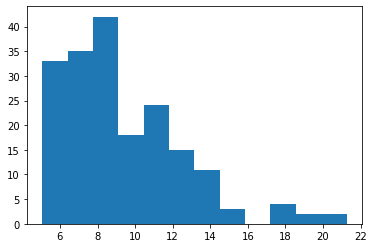

In [79]:

dld_ages=[]
for s in language_diff:
    subject_age_index = sub_age_list.tolist().index(s)
    dld_ages.append( sub_age[subject_age_index] )
    
plt.hist(dld_ages, bins=12)

Text(0.5, 1.0, 'all 2x <2SD CELF (n=189)')

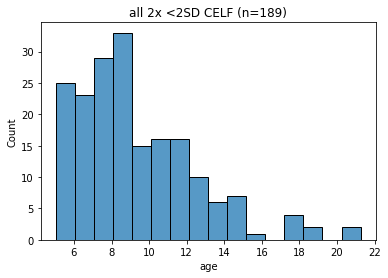

In [80]:
import seaborn as sns
sns.histplot(dld_ages, bins=16, stat='count')
plt.xlabel('age')
plt.title('all 2x <2SD CELF (n=189)')